In [ ]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
import os
import scipy.io as sio
import scipy
from scipy.spatial import distance
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys

# Modifier la variable du TD en fonction de l'endroit où les données sont stockées
TD_DIR = 'gdrive/My Drive/TD1/'
sys.path.append(TD_DIR)
#print(sys.path)
mat_contents = sio.loadmat(TD_DIR+"DrivFace.mat")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Load data
trainX=mat_contents['drivFaceD'][0,0][0]
y_init = mat_contents['drivFaceD'][0,0][2]
# Transform output encoding to one hot
trainY = np.zeros((y_init.size, y_init.max()))
trainY[np.arange(y_init.size),np.transpose(y_init-1)]=1


In [ ]:
class PD_algorithm(object):
  def __init__(self,trainX,trainY,sigma,tho,alpha,l):
    self.trainX = trainX
    self.trainY = trainY
    self.k=trainY.shape[1]
    self.m = trainX.shape[0]
    self.d=trainX.shape[1]
    self.sigma = sigma
    self.tho = tho
    self.alpha = alpha
    self.l=int(l)
    
    self.U = np.ones((self.k,self.l))
   
    ############### Initialise W and M randomly
    self.W = np.random.randn(self.d,self.l)
    #self.W = np.random.rand(self.d,self.l,density=0.5)
    self.M = np.random.randn(self.k,self.l)
    
  def initiate_weights(self):
    pca = PCA(self.l)
    pca.fit(self.trainX.T)
    self.W = pca.transform(trainX.T)
    kmeans = KMeans(n_clusters=3).fit(np.dot(trainX,self.W))
    self.M = kmeans.cluster_centers_
    print(self.W.shape)
    print(self.M.shape)


  def soft_v(self,W,v):
    return np.multiply(np.sign(W),np.maximum(np.abs(W)-(v),0))
  def prox_g(self,W):
    return self.soft_v(W,(self.tho*self.alpha))

  def proj_C(self,M):
    seuil  = round(M.sum(),9)
    if seuil >= 1:
      return M
    else :
      return M + (1/(self.k*self.l))*(1-seuil)*self.U
      print("out")
      
  def prox_f(self,Z):
    return Z - self.sigma*self.soft_v((1/self.sigma)*Z,1/self.sigma)

  def train(self):
    cost = []
    v_n = np.ones((self.m,self.l))
    for n in range(1000):
        M_n = self.M
        W_n = self.W
        self.W = self.prox_g(W_n + self.tho*np.dot(np.transpose(self.trainX),v_n))
        self.M = self.proj_C(M_n - self.tho*np.dot(np.transpose(self.trainY),v_n))
        v_n = self.prox_f(v_n + self.sigma*(np.dot(self.trainY,(2*self.M - M_n)) - np.dot(self.trainX,2*self.W - W_n)))
        diff = np.sum(np.abs(np.dot(self.trainY,self.M) - np.dot(self.trainX,self.W)))
        loss = diff + alpha*np.sum(np.abs(self.W))
        cost.append(loss)
        if (n%50 == 0):
          print("Iteration ", n, "lost :",diff)
    return cost
  def predict(self,testX):
    Y_p = np.transpose(distance.cdist(np.dot(testX,self.W),self.M).argmin(axis=1) ) 
    return Y_p
  


Iteration  0 lost : 35800706.72351112
Iteration  50 lost : 1848408.9985093866
Iteration  100 lost : 1444192.7516093291
Iteration  150 lost : 1165367.4950511665
Iteration  200 lost : 990696.7132900897
Iteration  250 lost : 930387.2205955088
Iteration  300 lost : 811760.9181047447
Iteration  350 lost : 742670.6488079063
Iteration  400 lost : 685130.343126365
Iteration  450 lost : 629712.4876343675
Iteration  500 lost : 584300.9669581105
Iteration  550 lost : 547301.5414816686
Iteration  600 lost : 510505.60738632386
Iteration  650 lost : 479084.675904616
Iteration  700 lost : 452097.9679186945
Iteration  750 lost : 425885.60903314664
Iteration  800 lost : 404384.45995359705
Iteration  850 lost : 383281.59984426067
Iteration  900 lost : 363439.40779083426
Iteration  950 lost : 344860.0043407071
[[ 27   0   0]
 [  0 546   0]
 [  0   2  31]]


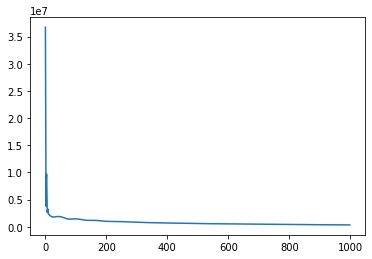

In [ ]:
# Parameters of the training algorithm
alpha = 5 
tho = 0.0001
sigma = 0.004
l = 500
model = PD_algorithm(trainX,
                     trainY,
                     alpha=alpha,
                     tho=tho,
                     sigma=sigma,
                     l=l)
model.initiate_weights
cost = model.train()
plt.yscale("log")
plt.plot(cost)


In [ ]:
# Prediction on test data

Y_p=model.predict(trainX)
# We add +1 to synchronise classes from [0-2] to [1-3]
C = confusion_matrix(y_init, 
                     Y_p+1)
print(C)